In [1]:
! pip install fastai
! pip install torch==2.0.1+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.2 -f https://download.pytorch.org/whl/cu117/torch_stable.html


^C


  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
     ---------------------------------------- 0.0/149.4 kB ? eta -:--:--
     -------------------------------------- 149.4/149.4 kB 9.3 MB/s eta 0:00:00
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl.metadata (34 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
     ---------------------------------------- 0.0/167.0 kB ? eta -:--:--
     ---------------------------------------- 167.0/167.0 kB ? eta 0:00:00
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB ? eta 0:00:00
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())


2.4.1+cu124
True


In [1]:
import os
import shutil
import random

def create_validation_set(train_dir, val_dir, split_ratio=0.2):
    # Create validation directory if it doesn't exist
    os.makedirs(val_dir, exist_ok=True)

    # Iterate over each label folder in the train directory
    for label in os.listdir(train_dir):
        label_path = os.path.join(train_dir, label)

        # Check if it is a directory (label folder)
        if os.path.isdir(label_path):
            images = os.listdir(label_path)
            # random.shuffle(images)  # Shuffle the images

            # Calculate the number of validation images (20% of total)
            val_size = int(len(images) * split_ratio)

            # Select the validation images
            val_images = images[:val_size]

            # Create label subdirectory in the validation directory
            os.makedirs(os.path.join(val_dir, label), exist_ok=True)

            # Move validation images to validation directory
            for image in val_images:
                shutil.move(os.path.join(label_path, image), os.path.join(val_dir, label, image))

if __name__ == "__main__":
    # Define the train directory and the validation directory
    train_directory = './screen_caps/train'  # Example: 'train'
    val_directory = './screen_caps/valid'      # Example: 'val'

    # Create the validation set
    create_validation_set(train_directory, val_directory, split_ratio=0.2)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './screen_caps/train'

pretrained model

In [2]:
from fastai.vision.all import *

path = Path("./screen_caps")

# Create a DataLoader for training
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                   item_tfms=Resize(224), batch_tfms=aug_transforms(), 
                                   bs=64)



# Define the model using FastAI's `cnn_learner` function
# ResNet is a commonly used architecture. You can replace resnet34 with any other architecture
learner = cnn_learner(dls, resnet34, metrics=accuracy)


# Train the model
learner.fine_tune(10)  # Train for 10 epochs

learner.save('model')

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,2.280041,1.816031,0.284483,01:18


epoch,train_loss,valid_loss,accuracy,time
0,2.052748,1.652797,0.336207,01:27
1,1.956285,1.552629,0.327586,01:25
2,1.881240,1.995276,0.252874,01:22
3,1.810206,1.515904,0.310345,01:22
4,1.707793,1.384849,0.405172,01:22
5,1.611469,1.392330,0.347701,01:22
6,1.545098,1.276369,0.387931,01:23
7,1.434225,1.266422,0.390805,01:22
8,1.371032,1.275477,0.399425,01:22
9,1.331322,1.273682,0.402299,01:22


Path('screen_caps/models/model.pth')

In [4]:
from fastai.vision.all import *
from mss import mss
import numpy as np
import cv2
import time
import pygetwindow as gw
from vgamepad import VDS4Gamepad

# Set up the screen capture and gamepad simulation
class ScreenCapture:
    def __init__(self, game_area=None):
        self.capture = mss()  # Correct mss initialization
        if game_area is None:
            game_area = self.get_game_window_coords()
            if game_area is None:
                raise ValueError("Game window not found.")
            self.game_area = {
                "left": game_area[0], 
                "top": game_area[1], 
                "width": game_area[2], 
                "height": game_area[3]
            }
        else:
            self.game_area = game_area

    def capture_frame(self):
        gamecap = np.array(self.capture.grab(self.game_area))
        return gamecap

    def get_game_window_coords(self, title="Forza Horizon 4"):
        game_window = gw.getWindowsWithTitle(title)
        if game_window:
            game_window = game_window[0]
            return game_window.left, game_window.top, game_window.width, game_window.height
        return None

# Set up the gamepad simulator
class GamepadSimulator:
    def __init__(self):
        self.gamepad = VDS4Gamepad()

    def set_input(self, lx, lt, rt):
        """Simulate controller inputs based on the model's prediction."""
        # Left joystick for steering (LX)
        self.gamepad.left_joystick(int((lx + 1) * 127), 128)
        
        # Left trigger (LT) for brake
        # self.gamepad.left_trigger(int(lt * 255))
        
        # Right trigger (RT) for gas
        self.gamepad.right_trigger(int(rt * 255))
        
        # Update the gamepad state
        self.gamepad.update()

# Load the trained model
def load_model():
    learner = cnn_learner(dls, resnet34, metrics=accuracy)
    learner.load('model')  # Load the saved model
    return learner

# Use the model to predict actions and simulate gamepad inputs
def drive_game(learner, screen_capture, gamepad_simulator, duration=60):
    start_time = time.time()
    
    while time.time() - start_time < duration:
        # Capture the game screen
        frame = screen_capture.capture_frame()
        
        # Convert the frame to a PIL image
        pil_img = PILImage.create(frame)
        if pil_img.mode == 'RGBA':
            pil_img = pil_img.convert('RGB')
        
        # Predict the next action using the trained model
        pred, _, _ = learner.predict(pil_img)
        
        # Extract the predicted action (you can modify this part to map to your controller actions)
        action = pred
        print(f"Predicted Action: {action}")
        
        # Simulate the controller inputs based on the prediction (implement your logic)
        if action == 'steer_left':
            gamepad_simulator.set_input(lx=-1, lt=0, rt=0)
        elif action == 'steer_right':
            gamepad_simulator.set_input(lx=1, lt=0, rt=0)
        # elif action == 'brake':
        #     gamepad_simulator.set_input(lx=0, lt=1, rt=0)
        elif action == 'gas':
            gamepad_simulator.set_input(lx=0, lt=0, rt=1)
        
        # Sleep for a short period to control the simulation speed
        time.sleep(0.1)

if __name__ == '__main__':
    # Initialize components
    screen_capture = ScreenCapture()
    gamepad_simulator = GamepadSimulator()
    learner = load_model()

    # Start driving the game for 60 seconds (you can adjust the duration)
    drive_game(learner, screen_capture, gamepad_simulator, duration=60)


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: brake


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: brake


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_right


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: brake


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_right


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_right


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


Predicted Action: gas


Predicted Action: gas


Predicted Action: steer_left


Predicted Action: steer_left


custom model

In [ ]:
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
import torch.nn as nn
from PIL import Image


path = Path("path_to_your_dataset")

im = Image.open(path + 'cat/cat.1.jpg')
im.to_thumb(128,128)

filenames = get_image_files(path)
filenames

#virify images
failed = verify_images(filenames)
failed

splitter=RandomSplitter(valid_pct=0.2, seed=42)
item_tfms=Resize(128)

# Define a custom CNN
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=3)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128*output_dim_x*output_dim_y, 5)  # Adjust output dim after flatten

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Create data loaders
dls = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), batch_tfms=aug_transforms(), bs=64)

# Wrap your model into a Learner
learner = Learner(dls, MyModel(), metrics=accuracy)

# Train the custom model
learner.fit_one_cycle(10)

# Regression model

Data preperation

In [1]:
from fastai.vision.all import *
import pandas as pd
import re

# Path to your images
path = Path("./screen_caps_edited")

# List all the image filenames in the folder
filenames = [f.name for f in path.ls() if f.name.endswith('.jpg')]  # Adjust file extension if needed

# Extract controller values from filenames using regex
def extract_controller_values(file_name):
    pattern = r'(?P<timestamp>\d{8}_\d{6})_(?P<LX>[-0-9.]+)_(?P<LT>[-0-9.]+)_(?P<RT>[-0-9.]+)\.jpg$'
    match = re.search(pattern, file_name)
    if match:
        return int(match.group('timestamp')), float(match.group('LX')), float(match.group('LT')), float(match.group('RT'))
    else:
        print('NO MATCH FOUND')
        return None  # Return None if no match is found

# Generate labels using the filenames
labels = [extract_controller_values(fn) for fn in filenames]

# Create a DataFrame to map filenames to their controller inputs
df = pd.DataFrame({
    'filename': filenames,
    'timestamp': [label[0] for label in labels],
    'LX': [label[1] for label in labels],
    'LT': [label[2] for label in labels],
    'RT': [label[3] for label in labels]
})

# Define the DataBlock for training a regression model
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),  # Images as inputs and regression labels
    get_x=ColReader('filename', pref=path),  # Get the file path from the 'filename' column
    get_y=ColReader(['LX', 'LT', 'RT']),  # Get the controller values
    splitter=RandomSplitter(valid_pct=0.2),  # Split 80% for training, 20% for validation
    item_tfms=Resize(224),  # Resize images to 224x224 (adjust as needed)
    batch_tfms=aug_transforms(
        max_rotate=10,   # Small rotation (up to 10 degrees), mimicking slight steering adjustments
        max_zoom=1.1,    # Zoom in/out slightly to simulate different distances
        max_warp=0.2,    # Warp the image a bit to simulate perspective changes
        max_lighting=0.2,  # Adjust brightness and contrast
        p_affine=0.75,   # Probability of applying affine transforms (zoom, rotate, warp)
        p_lighting=0.75,  # Probability of applying lighting transforms
        do_flip=False,   # Disable horizontal flips since that would make left/right confusing
    )
)

# Create DataLoaders
dls = dblock.dataloaders(df, bs=64)



#### DO NOT RUN

In [5]:
import shutil
from pathlib import Path
import os



# Create a new directory to store the copied images
output_dir = Path("./filtered_images")
output_dir.mkdir(exist_ok=True)

# Filter the DataFrame for images with LX > 0.75 or LX < -0.75
filtered_df = df[(df['LX'] > 0.75) | (df['LX'] < -0.75)]
# filtered_df = 
# Path to your source images
source_dir = Path("./screen_caps")

# Copy the filtered images to the new directory
for index, row in filtered_df.iterrows():
    source_file = source_dir / row['filename']

    timestamp, LX, LT, RT = extract_controller_values(row['filename'])
    timestamp = timestamp + 1000
    timestamp = str(timestamp)
    timestamp = f"{timestamp[:8]}_{timestamp[8:]}"
    destination_filename = f'{timestamp}_{round(LX,4)}_{round(LT,4)}_{round(RT,4)}.jpg'

    destination_file = output_dir / destination_filename
    
    # Copy the image
    shutil.copy(source_file, destination_file)

print(f"Copied {len(filtered_df)} images to {output_dir}")


Copied 2961 images to filtered_images


In [7]:
df.head()
df.describe()

,timestamp,LX,LT,RT
count,2.390900e+04,23909.000000,23909.000000,23909.000000
mean,2.024101e+13,-0.000669,-0.829581,0.489967
std,1.502576e+06,0.701180,0.542471,0.834143
min,2.024101e+13,-1.000000,-1.000000,-1.000000
25%,2.024101e+13,-0.756900,-1.000000,-0.019600
50%,2.024101e+13,0.019600,-1.000000,1.000000
75%,2.024101e+13,0.701900,-1.000000,1.000000
max,2.024101e+13,1.000000,1.000000,1.000000


Training the model

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0030199517495930195)

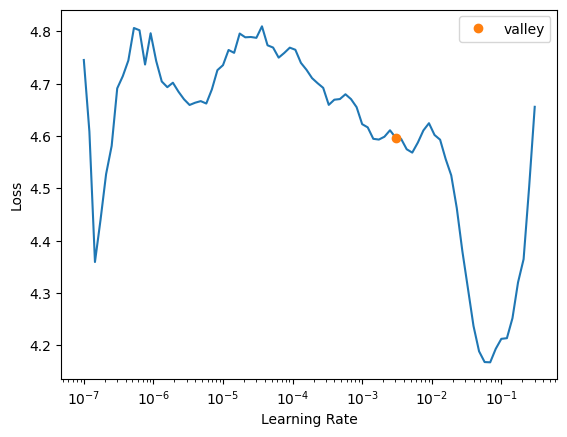

In [2]:
from fastai.metrics import mse

# Define the model with MSE loss for regression
learner = cnn_learner(dls, resnet50, loss_func=MSELossFlat(), metrics=[mse])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming `learner` is your model
learner.model = learner.model.to(device) 

learner.to_fp16()
learner.lr_find()
# learner.recorder.plot_lr_find()

# learner.freeze()

# Train the model
# learner.fine_tune(20)  # Fine-tune for 10 epochs (you can adjust this)

# # learner.unfreeze()  # Unfreeze all layers
# # learner.fit_one_cycle(5, lr_max=1e-5)  # Train for 5 more epochs with a lower learning rate

# # Save the trained model
# learner.save('model')

# learner.recorder.plot_loss()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,1.866695,0.662665,0.662665,03:41
1,0.566150,0.499185,0.499185,03:29
2,0.527026,0.481675,0.481675,03:29
3,0.473663,0.396208,0.396208,03:28
4,0.424035,0.378254,0.378254,03:28
5,0.386377,0.350977,0.350977,03:25
6,0.368273,0.313381,0.313381,03:23
7,0.342812,0.303412,0.303412,03:27
8,0.336182,0.296135,0.296135,03:25
9,0.332254,0.296954,0.296954,03:23


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.00015848931798245758)

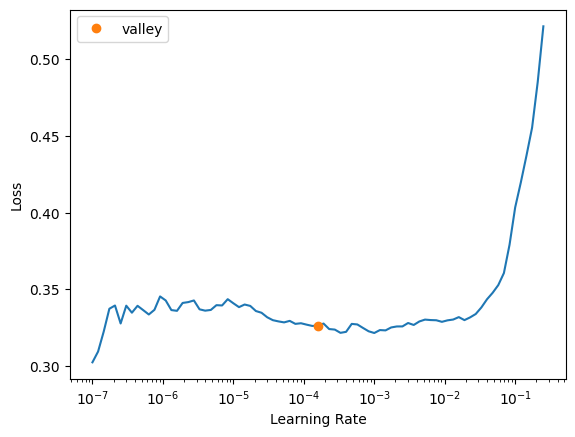

In [3]:
learner.fit_one_cycle(10, lr_max=3e-3)
# learner.unfreeze()
learner.lr_find()


In [4]:
# learner.fine_tune(20, base_lr=1e-3)  # Fine-tune for 10 epochs (you can adjust this)
# learner.unfreeze()
learner.fit_one_cycle(5, lr_max=1e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.332919,0.297717,0.297717,03:24
1,0.324782,0.293365,0.293365,03:26
2,0.331845,0.293570,0.293570,03:24
3,0.329873,0.295464,0.295464,03:23
4,0.330545,0.295988,0.295988,03:28


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.001737800776027143)

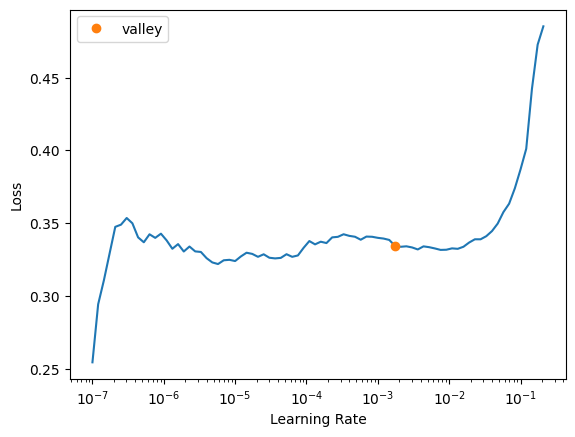

In [5]:
learner.lr_find()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.329416,0.294298,0.294298,03:36
1,0.337291,0.294127,0.294127,03:35
2,0.321079,0.286726,0.286726,03:11
3,0.321970,0.280904,0.280904,02:57
4,0.316378,0.280367,0.280367,03:05


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

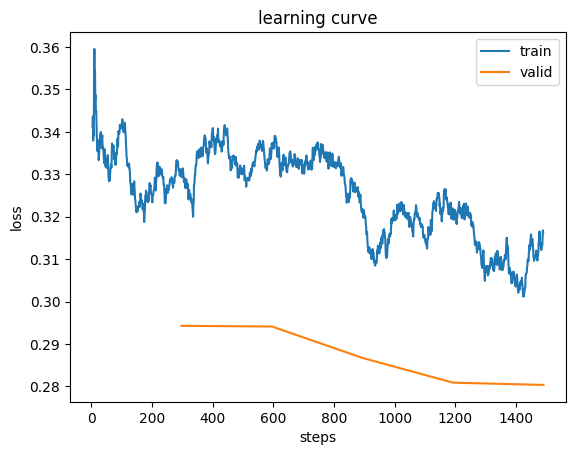

In [6]:
learner.fit_one_cycle(5, lr_max=1e-3)

learner.recorder.plot_loss()

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0010000000474974513)

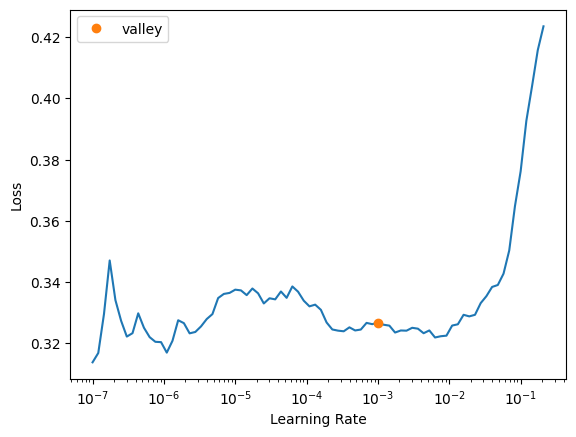

In [7]:
learner.lr_find()

In [8]:
learner.fit_one_cycle(5, lr_max=1e-3)

epoch,train_loss,valid_loss,mse,time
0,0.313911,0.285655,0.285655,03:24
1,0.318991,0.274912,0.274912,03:26
2,0.306041,0.272851,0.272851,03:26
3,0.298457,0.266201,0.266201,03:31
4,0.296165,0.266364,0.266364,03:30


SuggestedLRs(valley=0.00363078061491251)

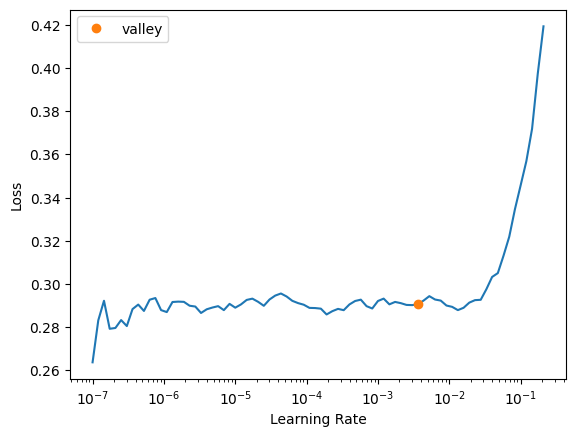

In [9]:
learner.lr_find()

In [10]:
learner.unfreeze()
learner.fit_one_cycle(5, lr_max=3e-3)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.410149,0.594125,0.594125,03:36
1,0.416055,0.394637,0.394637,03:36
2,0.373942,0.341068,0.341068,03:35
3,0.330298,0.304754,0.304754,03:37
4,0.298727,0.285159,0.285159,03:36


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0008317637839354575)

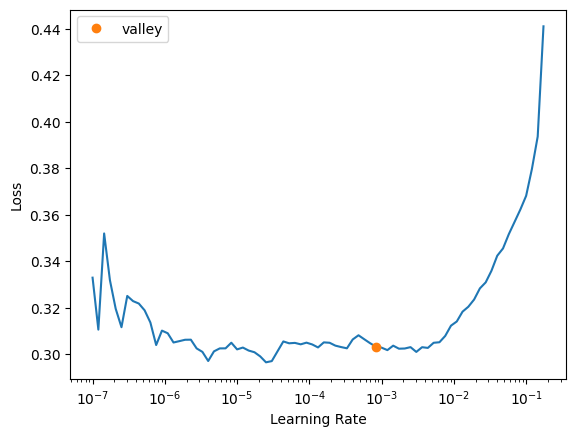

In [11]:
learner.lr_find()

In [12]:
learner.fit_one_cycle(5, lr_max=8e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.303533,0.310426,0.310426,03:31
1,0.316735,0.304210,0.304210,03:36
2,0.285598,0.275657,0.275657,03:35
3,0.271073,0.249528,0.249528,03:38
4,0.261588,0.248697,0.248697,03:35


c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0003981071640737355)

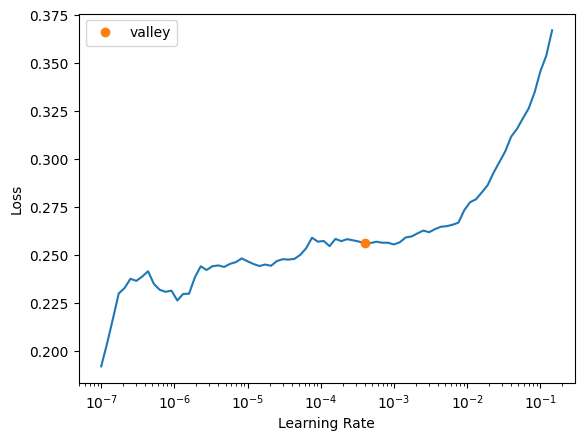

In [13]:
learner.lr_find()

In [14]:
learner.fit_one_cycle(5, lr_max=4e-4)

c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Jeffr\Documents\School\IT\Deep Learning\CVC_challenge\CVC_challenge_env\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,mse,time
0,0.259777,0.249490,0.249490,03:41
1,0.262778,0.255153,0.255153,03:28
2,0.253989,0.235727,0.235727,03:11
3,0.236626,0.226852,0.226852,03:10
4,0.233307,0.228203,0.228203,03:11


In [15]:
learner.save('model')

Path('models/model.pth')

## Drive

In [6]:
from fastai.vision.all import *
from mss import mss
import numpy as np
import cv2
import time
import pygetwindow as gw
from vgamepad import VDS4Gamepad

# Set up the screen capture and gamepad simulation
class ScreenCapture:
    def __init__(self, game_area=None):
        self.capture = mss()  # Correct mss initialization
        if game_area is None:
            game_area = self.get_game_window_coords()
            if game_area is None:
                raise ValueError("Game window not found.")
            self.game_area = {
                "left": game_area[0], 
                "top": game_area[1], 
                "width": game_area[2], 
                "height": game_area[3]
            }
        else:
            self.game_area = game_area

    def capture_frame(self):
        gamecap = np.array(self.capture.grab(self.game_area))
        return gamecap
    
    def resize_frame(self, frame):
        # Cut top 30% off the frame, to reduce distractions        
        # Get the dimensions of the image
        height, width, _ = frame.shape
        
        # Calculate the height to cut off
        cut_height = int(height * 0.30)

        # Cut the image by slicing the array
        cropped_frame = frame[cut_height:height, 0:width]  # Cuts off the top part

        return cropped_frame

    def get_game_window_coords(self, title="Forza Horizon 4"):
        game_window = gw.getWindowsWithTitle(title)
        if game_window:
            game_window = game_window[0]
            return game_window.left, game_window.top, game_window.width, game_window.height
        return None

# Set up the gamepad simulator
class GamepadSimulator:
    def __init__(self):
        self.gamepad = VDS4Gamepad()

    def set_input(self, lx, lt, rt):
        """Simulate controller inputs based on the model's prediction."""
        # Left joystick for steering (LX)
        LX = round(int((lx + 1) * 127), 3)
        brake_value = round(int(((lt + 1) / 2) * 255), 3)  # Convert -1,1 to 0,255
        gas_value = round(int(((rt + 1) / 2) * 255), 3)  # Convert -1,1 to 0,255

        # print(f"Predicted LX: {LX}, LT: {brake_value}, RT: {gas_value}")


        priority = max(brake_value, gas_value)

        if priority == brake_value:
             # Left trigger (LT) for brake - Map [-1, 1] to [0, 255]
             self.gamepad.left_trigger(brake_value)
        elif priority == gas_value:
            gas_value = int(gas_value)
            # Right trigger (RT) for gas - Map [-1, 1] to [0, 255]
            self.gamepad.right_trigger(gas_value)

        # LX = max(min(LX, 1), -1)
        self.gamepad.left_joystick(LX, 128) # LX is between -1 and 1
        
        # Update the gamepad state
        self.gamepad.update()
        time.sleep(0.01)

    def reset(self):
        self.gamepad.reset()
        self.gamepad.update()



# Load the trained regression model
def load_model():
    # Since you're using a regression model, remove the accuracy metric
    learner = cnn_learner(dls, resnet50, loss_func=MSELossFlat())
    learner.load('model')  # Load the saved model
    return learner

# Use the model to predict actions and simulate gamepad inputs
def drive_game(learner, screen_capture, gamepad_simulator, duration=60):
    start_time = time.time()
    gamepad_simulator.reset()

    with open('gespeelde_data', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(["Time", "Predicted LX", "Predicted LT", "Predicted RT"])
        while time.time() - start_time < duration:
            # Capture the game screen
            frame = screen_capture.capture_frame()
            frame = screen_capture.resize_frame(frame)
            
            # Convert the frame to a PIL image
            pil_img = PILImage.create(frame)
            if pil_img.mode == 'RGBA':
                pil_img = pil_img.convert('RGB')
            
            # Predict the controller inputs (LX, LT, RT) using the trained model
            pred = learner.predict(pil_img)[0]  # Use the model's output
            
            # Extract the predicted LX, LT, RT values from the prediction
            lx, lt, rt = pred

            # Get the current timestamp relative to the start time
            current_time = time.time() - start_time

            # Write the predicted values to the CSV file
            # writer.writerow([current_time, lx, lt, rt])
            
            # Simulate the controller inputs based on the prediction
            gamepad_simulator.set_input(lx, lt, rt)
            
            # Print the predicted values for debugging
            # print(f"Predicted LX: {lx}, LT: {lt}, RT: {rt}")
            
            # Sleep for a short period to control the simulation speed
            time.sleep(0.1)

    gamepad_simulator.reset()

if __name__ == '__main__':
    # Initialize components
    time.sleep(5)
    print('start')
    screen_capture = ScreenCapture()
    gamepad_simulator = GamepadSimulator()
    print(gamepad_simulator.gamepad)
    learner = load_model()

    # Start driving the game for 60 seconds (you can adjust the duration)
    drive_game(learner, screen_capture, gamepad_simulator, duration=100)


start


Test gamepad

In [11]:
gamepad_simulator = GamepadSimulator()
gamepad_simulator.reset()

time.sleep(5) 
start_time = time.time()
while time.time() - start_time < 5:
    gamepad_simulator.set_input(-1, -1, 1)

gamepad_simulator.reset()

In [26]:
gamepad_simulator.reset()

In [ ]:
# Test screen capture
cap = ScreenCapture()
frame = cap.capture_frame()
cv2.imshow('Captured Frame', frame)
cv2.waitKey(0)


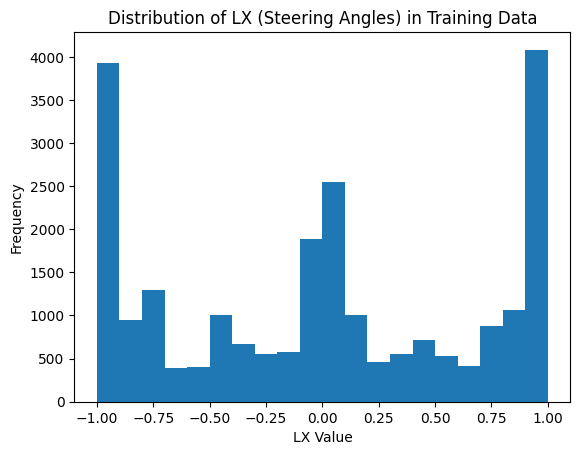

In [8]:
import matplotlib.pyplot as plt
plt.hist(df['LX'], bins=20)
plt.title('Distribution of LX (Steering Angles) in Training Data')
plt.xlabel('LX Value')
plt.ylabel('Frequency')
plt.show()


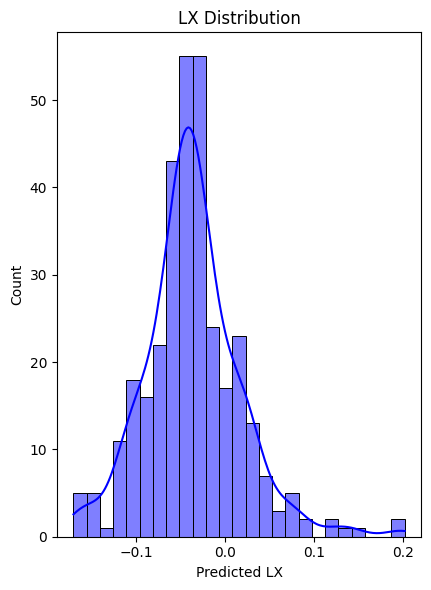

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file into a pandas DataFrame
df = pd.read_csv("gespeelde_data")

# Plot histogram for each of the LX, LT, and RT values
plt.figure(figsize=(12, 6))

# LX Histogram
plt.subplot(1, 3, 1)
sns.histplot(df['Predicted LX'], kde=True, color='blue')
plt.title('LX Distribution')
plt.xlabel('Predicted LX')

# Adjust layout
plt.tight_layout()
plt.show()


## RNN/LSTM

### Data Preprocessing

In [50]:
import torch
import numpy as np

# Sequence length (e.g., 10 frames per sequence)
sequence_length = 10

# Sort the DataFrame by timestamp to ensure sequential order
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Define a time gap threshold (e.g., 0.5 seconds)
time_gap_threshold = pd.Timedelta(seconds=0.5)

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Compute time differences between consecutive frames
df['time_diff'] = df['timestamp'].diff().fillna(pd.Timedelta(seconds=0))

path = Path("./screen_caps_edited")

# Function to create sequences, breaking at gaps
def create_sequences_with_gaps(df, sequence_length, time_gap_threshold):
    X, y = [], []
    current_sequence_x, current_sequence_y = [], []
    
    for i, row in df.iterrows():
        if len(current_sequence_x) == sequence_length:
            X.append(current_sequence_x)
            y.append(current_sequence_y)
            current_sequence_x, current_sequence_y = [], []
        
        # Add current data to sequence
        current_sequence_x.append(str(path / row['filename']))
        current_sequence_y.append([row['LX'], row['LT'], row['RT']])
        
        # If the time difference exceeds the threshold, break the sequence
        if row['time_diff'] > time_gap_threshold:
            if len(current_sequence_x) > 0:
                X.append(current_sequence_x)
                y.append(current_sequence_y)
            current_sequence_x, current_sequence_y = [], []
            
    # Convert lists to numpy arrays before returning
    return X, y

X_sequences, y_sequences = create_sequences_with_gaps(df, sequence_length=10, time_gap_threshold=time_gap_threshold)

# Check the shape of the resulting data
# print(X_sequences.shape)  # Expected: (num_sequences, sequence_length)
# print(y_sequences.shape)  # Expected: (num_sequences, sequence_length, 3)


In [45]:
# Print the first few elements of X_sequences to check their types
print("First few items in X_sequences:")
for seq in X_sequences[:5]:  # Adjust the slice as needed
    print([fn for fn in seq])  # Print the type of each filename in the sequence


First few items in X_sequences:
['screen_caps_edited\\20241010_180615_0.0431_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180616_0.0745_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180616_0.4745_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180617_0.0667_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180617_0.1216_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180618_-0.0118_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180619_-0.0118_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180619_-0.153_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180620_-0.3177_-1.0_0.7019.jpg', 'screen_caps_edited\\20241010_180620_-0.498_1.0_-1.0.jpg']
['screen_caps_edited\\20241010_180621_-0.4196_-1.0_0.8117.jpg', 'screen_caps_edited\\20241010_180621_-0.7255_0.1372_-1.0.jpg', 'screen_caps_edited\\20241010_180622_-0.5137_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180622_-0.6941_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180623_-0.6863_-1.0_1.0.jpg', 'screen_caps_edited\\20241010_180624_-0.6392_-1.0_1.0.jpg', 'scr

### Create Datablock

In [57]:
from fastai.vision.all import *
import numpy as np
import pandas as pd
import torch

# Custom DataLoader for handling sequences of images
class SequenceDataLoader(TfmdDL):
    def create_batch(self, b):
        # Unpack the batch into filenames (for images) and labels
        filenames, labels = zip(*b)
        
        # Load the sequence of images
        images = []
        for sequence in filenames:
            # Ensure sequence is a list of filenames
            img_sequence = [PILImage.create(fn) for fn in sequence]  # Load images
            
            # Apply Resize and convert to tensor using ToTensor()
            img_sequence = [ToTensor()(Resize(224)(img)) for img in img_sequence]
            
            # Stack images in the sequence along the 0th dimension (sequence_length, channels, height, width)
            img_sequence = torch.stack(img_sequence, dim=0)
            images.append(img_sequence)
        
        # Stack the entire batch of sequences into a single tensor
        images = torch.stack(images)  # (batch_size, sequence_length, channels, height, width)
        
        # Ensure labels are a tensor of appropriate shape
        # If `labels` is a sequence, stack them properly
        if isinstance(labels[0], (list, np.ndarray)):
            labels = [torch.tensor(lbl, dtype=torch.float32) for lbl in labels]
            labels = torch.stack(labels)
        else:
            labels = torch.tensor(labels, dtype=torch.float32)  # Ensure labels are float32
        
        return images, labels

# Custom getters for sequences
def get_x(item):
    return item['X']  # Return the filenames for the images

def get_y(item):
    return item['y']  # Return the joystick controls

# Create the DataBlock for image sequences using TransformBlock instead of ImageBlock
dblock_rnn = DataBlock(
    blocks=(TransformBlock, RegressionBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2),  # 80% training, 20% validation
)

# Create DataFrame for sequences (lists of image filenames and joystick labels)
df_sequences = pd.DataFrame({
    'X': pd.Series(X_sequences, dtype='object'),  # Store sequences (lists) as objects
    'y': pd.Series(y_sequences, dtype='object')   # Store labels (lists) as objects
})

# Create DataLoaders using the custom SequenceDataLoader
dls_rnn = dblock_rnn.dataloaders(df_sequences, bs=16, dl_type=SequenceDataLoader)

# Example to check the DataLoader
for batch in dls_rnn.train:
    images, labels = batch
    print(f"Images shape: {images.shape}")  # Should show (bs, sequence_length, channels, height, width)
    print(f"Labels shape: {labels.shape}")  # Should show (bs, sequence_length, 3) or (bs, 3)
    break  # To avoid printing all batches, just show the first one


Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


ValueError: only one element tensors can be converted to Python scalars